# Multi-Attribute Analysis
The following notebook can analyze a given attribute with any number of expected values (2+), and will perform metrics 1,2,3,4,11 as previously specified in Gender Analysis.ipynb, except generalized to any attribute

## Instruction
1. Fill in the dataset in section 1.1

2. Fill in attribute information in 1.2

3. Run all of the cells

4. Look at the summary pdf generated AND/OR explore each metric below.
    - Under each Metric there will be a portion of "Setup" and then "Analyses". Ignore the "Setup" unless customization is needed, and in "Analyses" results are shown to be interacted with. The number that comes after the M in the title refers to the measurement number when collecting the metrics.
    
## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset) <br/>
    1.2 [Attribute](#attribute)
2. (M1) Metric: [Distance from center, size, gender label inference](#metric1)<br/>
    2.1 [Setup](#metric1_setup)<br/>
    2.2 [Analyses](#metric1_analyses)

## Initial Setup
<a id="setup"></a>

In [2]:
from __future__ import print_function
import argparse
import datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
os.environ["PROJ_LIB"] = "/Users/anatk/opt/miniconda3/pkgs/basemap-1.2.2-py37h2d053a3_3/share/basemap/"
from mpl_toolkits.basemap import Basemap
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import plotly.graph_objects as go
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
import time
import warnings
import random
from matplotlib.transforms import Bbox
from IPython.display import clear_output

In [3]:
COLORS = sns.color_palette('Set2')
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [4]:
%matplotlib inline

In [5]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [6]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def display_filepaths(filepaths, width=100, height=100):
    sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
    display(sidebyside)

def dec_to_show(p):
    if p < .001:
        return '{:0.3e}'.format(p)
    else:
        return round(p, 3)

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [7]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
dataset = datasets.CoCoDataset(transform_train)
folder_name = 'coco_example'

# dataset = datasets.OpenImagesDataset(transform_train)
# folder_name = 'openimages_supp'

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [8]:
save_loc = '1_pager_gen'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}
if not os.path.exists("checkpoints/{}".format(folder_name)):
    os.mkdir("checkpoints/{}".format(folder_name))

In [9]:
data_folder = None
data_folder = "coco_results"

distances = pickle.load(open("results/{}/3.pkl".format(folder_name), "rb"))
sample_file = distances[0][0][0][3]
if not os.path.exists(sample_file):
    assert data_folder is not None, "initialize data_folder with folder path of your data"
    dataset.init_folder_path(data_folder)
    print("overwriting from_path() function")
    dataset.from_path = dataset.from_path_prerun

FileNotFoundError: [Errno 2] No such file or directory: 'results/coco_example/3.pkl'

## Attribute
Fill in below with information about attribute you would like to analyze
<a id="attribute"></a>

In [10]:
#User changes according to how many possible values for an attribute
num_attrs = 2
#Labels to names for a given attribute
attr_names = ["female", "male"]
#Which index attribute to focus on (e.g. male)
analyze_attr = 1

num_attrs = 3
attr_names = ["Dark", "Light", "Unsure"]

# (M1) Metric: Distance from center, size, attribute label inference

## Setup
Fill in below with number of attribute values (e.g. 2 possible values), the assigned labels names, and which attribute you want the metric to focus on (e.g. female)

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide M1 code')

In [12]:
info = pickle.load(open("results/{}/1.pkl".format(folder_name), "rb"))
sizes = info['sizes']
dists = info['distances']
tiny_sizes = info['tiny_sizes']
no_faces = info['noface_sizes']


#Used for debuggin purposes on val2017 to prevent any empty lists
#for attr in range(num_attrs):
#    if len(tiny_sizes[attr])==0:
#        tiny_sizes[attr].append((0.003232840310304449, [1]))
        

#Can have any number of each
scenes = [None]*num_attrs
for attr in range(num_attrs):
    try:
        scenes[attr]=np.array(list(itertools.chain.from_iterable([chunk[2] for chunk in no_faces[attr]])) + list(itertools.chain.from_iterable([chunk[1] for chunk in tiny_sizes[attr]])))
    except TypeError:
        if len(tiny_sizes)==0:
            print("Tiny sizes is empty for {0}".format(attr_names[attr]))
        else:
            print("No faces is empty for {0}".format(attr_names[attr]))
    tiny_sizes[attr] = [chunk[0] for chunk in tiny_sizes[attr]]
    no_faces[attr] = [chunk[0] for chunk in no_faces[attr]]
    
info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']


xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .4
fontsize = 15

r1 = np.arange(len(idx_to_scenegroup))
r1 = r1 * ((barWidth * num_attrs) + .2)

scenes = [np.bincount(scenes[i]) for i in range(num_attrs)]


total_images = np.sum(np.sum(scenes, axis = 0))
print("total images: ", total_images)

scenes_ratio = [scenes[i]/total_images for i in range(num_attrs)]
scenes_total = np.sum(scenes_ratio, axis = 0) - scenes_ratio[analyze_attr]


all_sizes = [tiny_sizes[i]+no_faces[i]+sizes[i] for i in range(num_attrs)]

    
def numbers_where_attribute_inferred():
    tiny = [len(tiny_sizes[i]) for i in range(num_attrs)]
    
    noface = [len(no_faces[i]) for i in range(num_attrs)]
    
    
    original = [tiny[i]+noface[i]+len(sizes[i]) for i in range(num_attrs)]
    total_original = np.sum(original)
    
    
    
    print("Total images: {0},".format(total_original))
    for i in range(num_attrs):
        print("{0} were {1}".format(original[i], attr_names[i]))
    print("{0}.x".format(round(original[analyze_attr]/total_original, 4)))
        
        
    tiny_total = np.sum(tiny)
    
    print("Discarded {0} images for being too small,".format(tiny_total))
    for i in range(num_attrs):
        print("{0} were {1}".format(tiny[i], attr_names[i]))
    print("{0}.x".format(round(tiny[analyze_attr]/tiny_total, 4)))

        
    noface_total = np.sum(noface)
    print("Discarded {0} images for having no face detected,".format(noface_total))
    for i in range(num_attrs):
        print("{0} were {1}".format(noface[i], attr_names[i]))
    print("{0}.x".format(round(noface[analyze_attr]/noface_total, 4)))

            
    
    labelled_attr = tiny[analyze_attr]+noface[analyze_attr]
    labelled_others = np.sum([tiny[i]+noface[i] for i in range(num_attrs)])
    prob = labelled_attr / labelled_others
    
    prob_statement = "Probability image is labeled {0} when it should not be, i.e. given there's no face detected or person is too small: {1}".format(attr_names[analyze_attr], round(prob, 4))

    
    if (prob < .45 or prob > .55) and first_pass:
        to_write[0] = ["(M1) " + prob_statement]
    print()
    print(prob_statement)
    
    
def scenes_where_no_face():
    barWidths = [barWidth * i for i in range(num_attrs)]
    fig = plt.figure(figsize=(12, 6))
    r = [r1]
    for i in range(1, num_attrs+1):
        r.append([x + barWidth for x in r[len(r)-1]])
        
    
    scene_attr_ratios = np.divide(scenes[analyze_attr], scenes_total)
    
    order = np.argsort(scene_attr_ratios)
    
    
    biggest_diff_scenes = []
    if first_pass and scene_attr_ratios[order[-1]] > 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[-1]], attr_names[analyze_attr]))
    if first_pass and scene_attr_ratios[order[0]] < 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[0]], attr_names[analyze_attr]))
    if len(biggest_diff_scenes) > 0:
        to_write[1] = biggest_diff_scenes
        
    for i in range(num_attrs-1, -1, -1):
        plt.barh(r[i], scenes[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])
    
    
    plt.yticks(r[len(r)-1], np.array(xaxis)[order], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Scene', fontsize=fontsize)
    #May want to add attribute name in graph title
    plt.xlabel('Proportion of Images Discarded with this Scene', fontsize=fontsize)
    plt.legend(loc='best', prop={'size': fontsize})
    plt.title("Scenes where image was labeled when it should not have been", fontsize=fontsize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.18)
    plt.gcf().subplots_adjust(left=0.4)
    plt.show()
    
comparisons_widget = widgets.Dropdown(options=['Sizes', 'Distances', 'All sizes', 'Sizes where no face was detected'], value='Sizes')
prob_v_freq_toggle = widgets.ToggleButton(value=True, description="Probability View", layout=Layout(width='200px'))

def compare_sizedist(metric, view):
    def mean_and_std(data, data_type):


        hist_bins = [np.histogram(data[i], bins='auto')[1] for i in range(num_attrs)]

        bins = [-1]
        biggest = -1

        for i in range(num_attrs):
            
            if hist_bins[i][-1] > bins[-1]:
                bins = hist_bins[i]
        
       
        biggest = max(data[0])
        
        for i in range(1, len(data)):        
            try:
                biggest = max(max(data[i]), biggest)
            except ValueError:
                biggest= 1.

        prob_bins = np.arange(0, biggest, biggest / 15)

        hist_bins = [np.histogram(data[i], bins=prob_bins)[0]/len(data[i]) for i in range(num_attrs)]


        conditioned = np.divide(hist_bins[analyze_attr], np.sum(hist_bins, axis=0))

        mean = [np.mean(data[i]) for i in range(num_attrs)]

        std = [np.std(data[i]) for i in range(num_attrs)]


        #May want to change, atm it takes the least significant p, and if that's less than 0.05 then proceeds
        min_p = 100
        for i in range(num_attrs):
            if i != analyze_attr:
                t, p = stats.ttest_ind(data[i], data[analyze_attr])
                if p < min_p:
                    min_p=p
        p = min_p


        #May want to specify what "attributes" is
        to_save = False
        if view is None and p < .05 and first_pass:
            data_descrip = ''
            if data_type == 'dists':
                data_descrip = 'Distance from center'
            if data_type == 'sizes':
                data_descrip = 'Fraction of image taken up by a person'
            to_write[2] = ["(M1) {0} is different between the attributes with a p-value of {1} for the most significant pair, distribution shown below".format(data_descrip, dec_to_show(p))]
            to_save = True

        if view is None or view:

            prob_v_freq_toggle.description = 'Probability view'
            for i in range(num_attrs):
                histogram_a, bins_a = np.histogram(data[i], bins='auto')
                bin_centers_a = 0.5*(bins_a[1:] + bins_a[:-1])
                area_a = np.trapz(histogram_a, x=bin_centers_a)
                #Add more specific graph titles that feature attribute name?
                plt.plot(bin_centers_a, histogram_a/area_a, alpha=.75, label=attr_names[i], color=COLORS[i])

            plt.legend(loc='upper right')
            plt.xlabel('Distances' if data_type == 'distances' else 'Sizes')
            plt.ylabel('Frequency')
            if to_save and first_pass:
                plt.savefig("results/{0}/{1}/0.png".format(folder_name, save_loc))
                plt.close()
            elif view is None:
                plt.close()
            else:
                plt.show()
        else:
            prob_v_freq_toggle.description = 'Frequency view'
            plt.scatter(np.arange(len(conditioned)), conditioned)
            plt.plot(np.arange(len(conditioned)), [.5] * len(conditioned), color='red')
            plt.xticks(np.arange(len(conditioned)), ['{0} to {1}'.format(round(prob_bins[i], 2), round(prob_bins[i+1], 2)) for i in range(len(conditioned))], rotation='vertical', fontsize='6')
            plt.xlabel('Distances' if data_type == 'distances' else 'Sizes')
            plt.ylabel('Probability of {0}'.format(attr_names[analyze_attr]))
            plt.tight_layout()
            plt.show()

        if view is not None:
           
            for i in range(num_attrs):
                print("{0}: {1} +- {2}\n".format(attr_names[i], round(mean[i], 4), round(std[i], 4)))
            print("P value of greatest significance: {}\n".format('{:0.3e}'.format(p)))


    if metric == 'Sizes':
        mean_and_std(sizes, 'sizes')
    elif metric == 'All sizes':
        mean_and_std(all_sizes, 'all_sizes')
    elif metric == 'Sizes where no face was detected':
        mean_and_std(no_faces, 'no_faces')  
    elif metric == 'Distances':
        mean_and_std(dists, 'dists')
    elif metric == 'first_pass' and first_pass:
        mean_and_std(sizes, 'sizes')
        mean_and_std(dists, 'dists')




total images:  2097


Total images: 2318,
99 were Dark
1179 were Light
1040 were Unsure
0.5086.x
Discarded 3 images for being too small,
1 were Dark
1 were Light
1 were Unsure
0.3333.x
Discarded 1541 images for having no face detected,
70 were Dark
700 were Light
771 were Unsure
0.4543.x

Probability image is labeled Light when it should not be, i.e. given there's no face detected or person is too small: 0.454


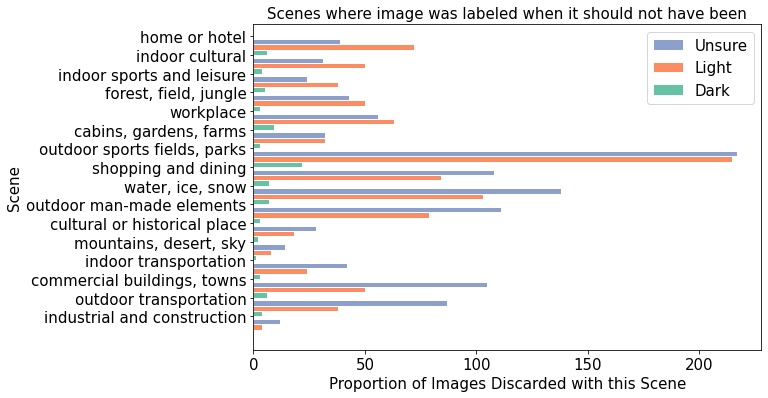

In [51]:
numbers_where_attribute_inferred()
scenes_where_no_face()

In [13]:
if first_pass:
    compare_sizedist('first_pass', None)
all_things = [comparisons_widget, prob_v_freq_toggle]
ui = HBox(all_things)
out = widgets.interactive_output(compare_sizedist, {'metric': comparisons_widget, 'view': prob_v_freq_toggle})
display(ui, out)

Output()